# Data Science for Biomedical Informatics: Final Project 
## The main question we are trying to answer is: What factors influences Airbnb pricing?
*The dataset we are using is through Kaggle*


By: Varsha Shashidhar + Sriya Nimmagadda

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

## Cleaning and Preprocessing Data ##

In [2]:
# drop rows with missing critical values
df = pd.read_csv(
    'AB_US_2023.csv',
    encoding='latin1',
    on_bad_lines='skip',
    engine='python'  # ← this is key
)

df_cleaned = df.dropna(subset=['name', 'host_name', 'reviews_per_month', 'last_review'])

# fill missing 'neighbourhood_group' with 'Unknown'
df_cleaned.loc[:, 'neighbourhood_group'] = df_cleaned['neighbourhood_group'].fillna('Unknown')

# remove listings with price <= 0 or extremely high prices
df_cleaned = df_cleaned[(df_cleaned['price'] > 0) & (df_cleaned['price'] <= 1000)]

# remove listings with minimum_nights > 365
df_cleaned = df_cleaned[df_cleaned['minimum_nights'] <= 365]

df_cleaned = df_cleaned.reset_index(drop=True)

df_cleaned

/var/folders/zh/5wyc67tn6p1f2g55tpwm_1gw0000gn/T/ipykernel_39495/1896325445.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.loc[:, 'neighbourhood_group'] = df_cleaned['neighbourhood_group'].fillna('Unknown')


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,city
0,958,"Bright, Modern Garden Unit - 1BR/1BTH",1169,Holly,Unknown,Western Addition,37.770280,-122.433170,Entire home/apt,202,2,383,2023-02-19,2.31,1,128,59,San Francisco
1,5858,Creative Sanctuary,8904,Philip And Tania,Unknown,Bernal Heights,37.744740,-122.420890,Entire home/apt,235,30,111,2017-08-06,0.66,1,365,0,San Francisco
2,8142,Friendly Room Apt. Style -UCSF/USF - San Franc...,21994,Aaron,Unknown,Haight Ashbury,37.765550,-122.452130,Private room,56,32,9,2022-10-27,0.09,13,365,1,San Francisco
3,8339,Historic Alamo Square Victorian,24215,Rosy,Unknown,Western Addition,37.775640,-122.436420,Entire home/apt,575,9,28,2019-06-28,0.17,2,365,0,San Francisco
4,8739,"Mission Sunshine, with Private Bath",7149,Ivan & Wendy,Unknown,Mission,37.760300,-122.421970,Private room,110,1,770,2023-02-25,4.65,2,159,34,San Francisco
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180164,837369168777380540,Cozy Bedroom for Traveler,417706467,Qiuying,Unknown,Unincorporated Areas,37.631403,-122.404954,Private room,60,1,2,2023-03-21,2.00,4,26,2,San Mateo County
180165,837376796422514183,Lovely Bedroom close to SFO,417706467,Qiuying,Unknown,Unincorporated Areas,37.629656,-122.404476,Private room,52,1,1,2023-03-17,1.00,4,24,1,San Mateo County
180166,837858369497137832,Cozy bedroom in the heart of Silicon Valley,6887379,Jimena,Unknown,Unincorporated Areas,37.459521,-122.265714,Entire home/apt,59,1,1,2023-03-11,1.00,3,252,1,San Mateo County
180167,838031150138816300,"246C - Large Studio w/ Kitchenette, Laundry & ...",250584391,Victor 5,Unknown,San Mateo,37.528251,-122.297826,Entire home/apt,100,2,1,2023-03-19,1.00,18,171,1,San Mateo County


## Sanity Checks ##

In [3]:
# Sanity Check 
df.shape
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180169 entries, 0 to 180168
Data columns (total 18 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              180169 non-null  int64  
 1   name                            180169 non-null  object 
 2   host_id                         180169 non-null  int64  
 3   host_name                       180169 non-null  object 
 4   neighbourhood_group             180169 non-null  object 
 5   neighbourhood                   180169 non-null  object 
 6   latitude                        180169 non-null  float64
 7   longitude                       180169 non-null  float64
 8   room_type                       180169 non-null  object 
 9   price                           180169 non-null  int64  
 10  minimum_nights                  180169 non-null  int64  
 11  number_of_reviews               180169 non-null  int64  
 12  last_review     

In [4]:
# check percentage of missing values
missing = df_cleaned.isna().sum()

missing /= df_cleaned.shape[0]
missing *=100
missing = missing.to_frame().rename(columns={0:'Percent Of Missing Values'})
missing

,Percent Of Missing Values
id,0.0
name,0.0
host_id,0.0
host_name,0.0
neighbourhood_group,0.0
neighbourhood,0.0
latitude,0.0
longitude,0.0
room_type,0.0
price,0.0


## Exploratory Data Analysis ##

### Numeric Features Distribution Analysis ###

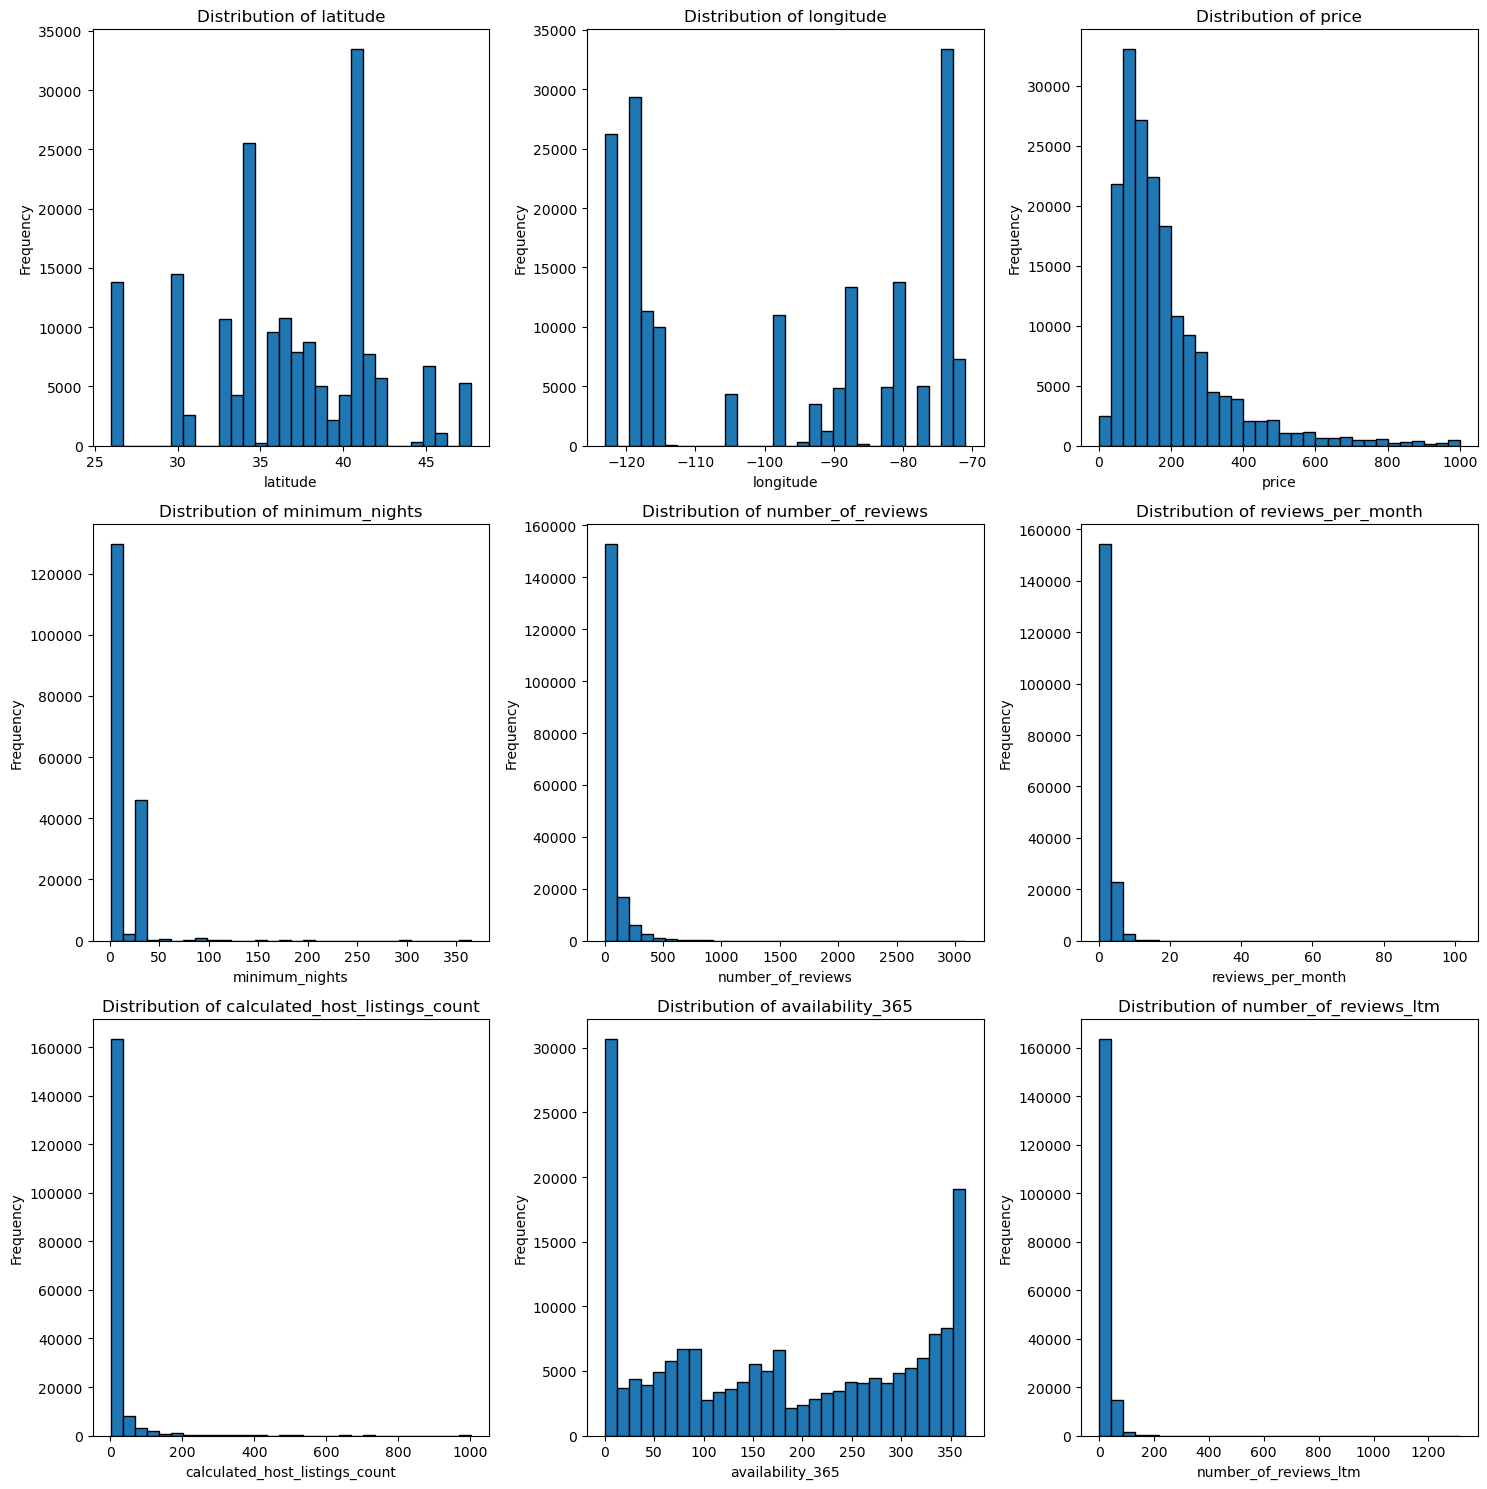

In [6]:
## Numeric features distribution analysis

# identify the numeric columns in the dataset + exclude 'id' and 'host_id'
numeric_columns = df_cleaned.select_dtypes(include=['float64', 'int64']).columns
numeric_columns_filtered = [col for col in numeric_columns if col not in ['id', 'host_id']]

# plot histograms for numeric features
numeric_features_filtered = df_cleaned[numeric_columns_filtered]

# adjust the number of rows and columns for subplots
num_features_filtered = len(numeric_features_filtered.columns)
rows_filtered = (num_features_filtered // 3) + (num_features_filtered % 3 > 0)
cols_filtered = 3

plt.figure(figsize=(15, rows_filtered * 5))

for i, column in enumerate(numeric_features_filtered.columns, 1):
    plt.subplot(rows_filtered, cols_filtered, i)
    plt.hist(numeric_features_filtered[column], bins=30, edgecolor='black')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Removing Outliers ###

In [7]:
def remove_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # define lower and upper bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # filter data to remove outliers
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df

# remove outliers
df_cleaned = remove_outliers(df, numeric_columns_filtered)


### Numeric Feature Distribution After Removing Outliers ###

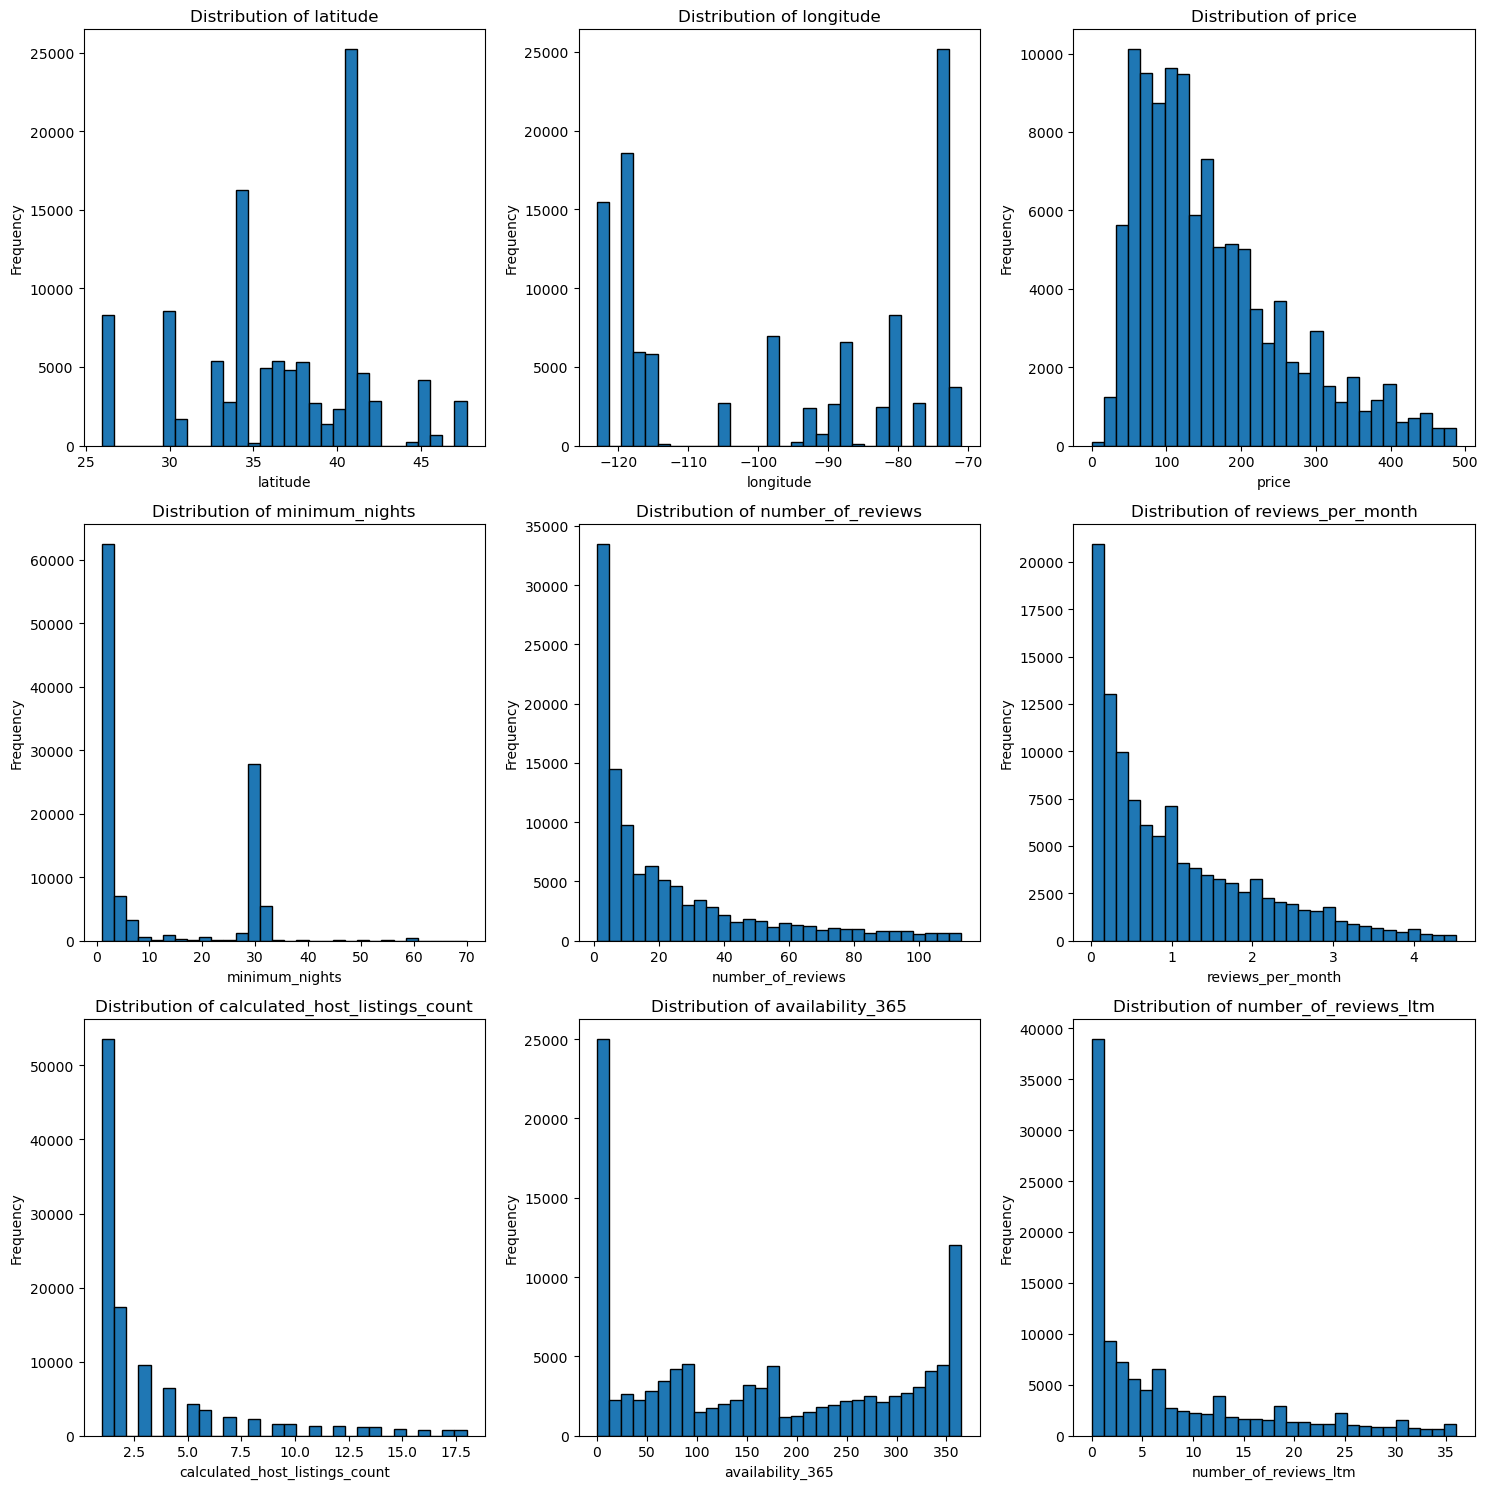

In [8]:
## Numeric Feature Distribution after removing outliers

numeric_columns = df_cleaned.select_dtypes(include=['float64', 'int64']).columns
numeric_columns_filtered = [col for col in numeric_columns if col not in ['id', 'host_id']]


numeric_features_filtered = df_cleaned[numeric_columns_filtered]

num_features_filtered = len(numeric_features_filtered.columns)
rows_filtered = (num_features_filtered // 3) + (num_features_filtered % 3 > 0)
cols_filtered = 3

plt.figure(figsize=(15, rows_filtered * 5))

for i, column in enumerate(numeric_features_filtered.columns, 1):
    plt.subplot(rows_filtered, cols_filtered, i)
    plt.hist(numeric_features_filtered[column], bins=30, edgecolor='black')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


After removing the outliers, we can especially see a difference in the distribution of number_of_reviews and distribution of number_of_reviews_per_month to change to a downwards exponential graph. After removing outliers, since the plot became more exponential, it can indicate that the outliers were the extreme data points that previously skewed the distribution. Now that they're removed, we can see more of the natural distribution, which can often resemble an exponential decay.

### Price Distribution Per Neighborhood ###

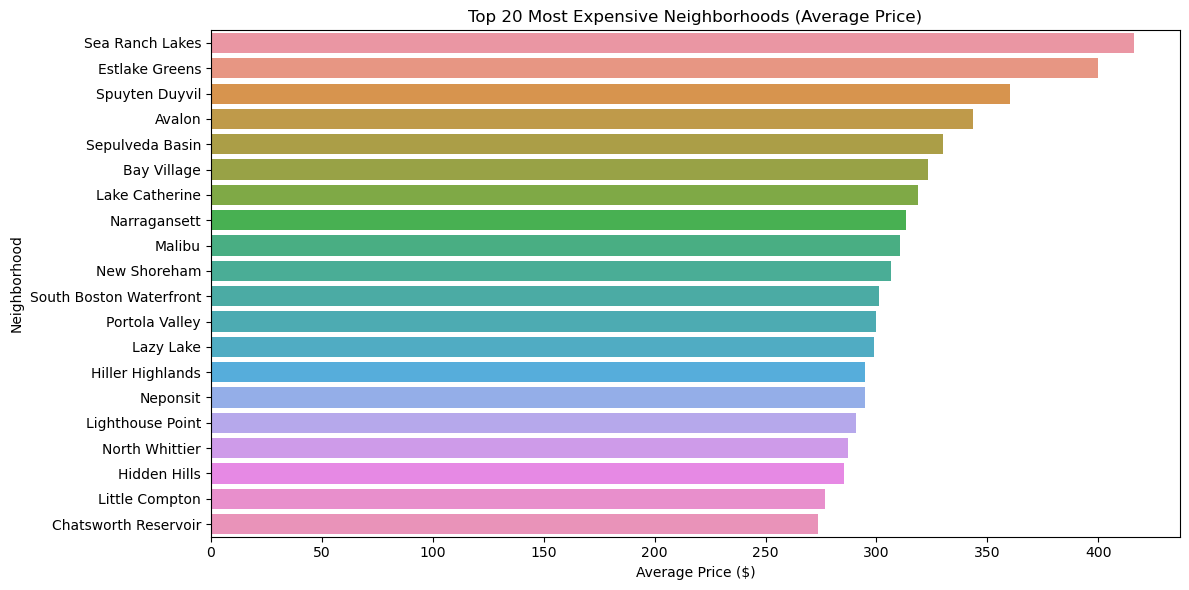

In [9]:
# price distribution per neighborhood
avg_price = df_cleaned.groupby('neighbourhood')['price'].mean().sort_values(ascending=False).head(20)

# graph to see distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_price.values, y=avg_price.index)
plt.title("Top 20 Most Expensive Neighborhoods (Average Price)")
plt.xlabel("Average Price ($)")
plt.ylabel("Neighborhood")
plt.tight_layout()
plt.show()

The graph displays the Top 20 Most Expensive Neighborhoods based on the average price of Airbnb listings. Sea Ranch Lakes stands out as the most expensive neighborhood, with an average price exceeding 400 dollars per night. Following closely are neighborhoods like Estlake Greens, Spuyten Duyvil, and Avalon, all with average prices over 250 dollars. As we move down the list, there is a clear decline in prices, with most of the top 20 neighborhoods falling within the 150 to 250 range. This suggests that while the top few neighborhoods are highly exclusive, many others remain expensive but slightly more accessible. These high prices are likely due to the demand for luxury or premium properties, often found in prime locations near tourist attractions or prestigious areas. The distribution indicates that these neighborhoods target high-income visitors and possibly offer unique amenities or experiences, driving up the average price. These neighborhoods likely have fewer listings but higher demand, contributing to their elevated pricing. Another thing to note is that Sea Ranch Lakes is right next to Fort Lauderdale beach in Florida, which explains the high prices due to its proximity to the beach.

## Linear Regression Model to Find Top Factors Influencing Price ##

In [10]:
# linear regression model to find factors that influence price
features = ['room_type', 'neighbourhood_group', 'minimum_nights', 'number_of_reviews',
            'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
target = 'price'

df_model = df_cleaned[features + [target]].dropna()
X = df_model[features]
y = df_model[target]

# split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_features = ['room_type', 'neighbourhood_group']
numeric_features = ['minimum_nights', 'number_of_reviews', 'reviews_per_month',
                    'calculated_host_listings_count', 'availability_365']

preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)],
    remainder='passthrough'
)

# pipeline to train data
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

model.fit(X_train, y_train)

# predict + evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

# feature coefficients
linreg_model = model.named_steps['regressor']
encoded_features = model.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([encoded_features, numeric_features])
coefficients = pd.Series(linreg_model.coef_, index=all_feature_names).sort_values(key=abs, ascending=False)
print("\nTop 10 Influential Features:")
print(coefficients.head(10))

Mean Squared Error: 5954.13
R² Score: 0.35

Top 10 Influential Features:
neighbourhood_group_Washington    89.219793
neighbourhood_group_Newport       80.795459
room_type_Shared room            -66.345650
room_type_Entire home/apt         61.434404
neighbourhood_group_Lake City    -44.312647
room_type_Hotel room              41.448422
neighbourhood_group_Manhattan     38.274183
room_type_Private room           -36.537177
neighbourhood_group_Bristol       35.912259
neighbourhood_group_Northgate    -34.656681
dtype: float64


The model’s performance suggests that there is room for improvement, with the R² score indicating that only 35% of the variance in the target variable is explained.

Washington and Newport neighborhoods are highly influential, leading to higher prices, while shared rooms and Lake City neighborhoods are associated with lower prices.

Room types play a significant role, with entire homes/apartments and hotel rooms having a positive impact, while shared rooms and private rooms tend to be associated with lower prices.

### Top 10 Influential Features ###

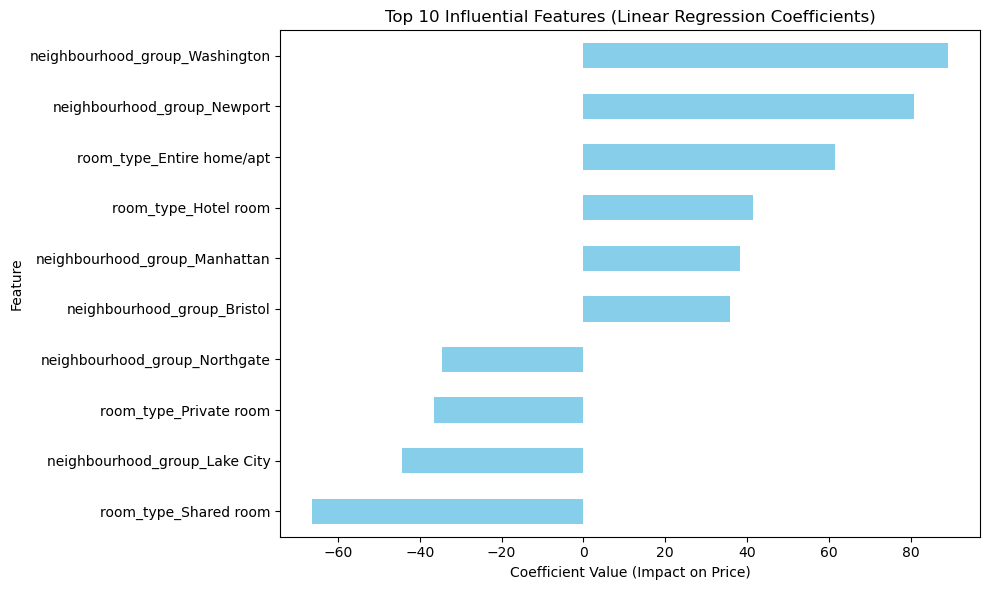

In [11]:
# plot top 10 influential features
plt.figure(figsize=(10, 6))
coefficients.head(10).sort_values().plot(kind='barh', color='skyblue')
plt.title("Top 10 Influential Features (Linear Regression Coefficients)")
plt.xlabel("Coefficient Value (Impact on Price)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

This shows that many features are either a positive or negative influence on price. For example, neighbourhood_group_Newport, neighbourhood_group_Washington, and room_type_Entire home/apt are priced significantly more than the baseline home. However, room_type_Shared room, room_type_Hotel room, and neighbourhood_group_Staten Island are priced less than average.

Overall, this means location and room type matter most in influencing price. Some premium tourist areas (like Newport, Kauai, Washington) significantly boost prices. Basic or shared accommodations lower the price sharply. The model doesn't capture all variability, suggesting other unmeasured factors (e.g., amenities, seasonality, host ratings, photos) also play a major role.

### Room Type Distribution ###

Entire home/apt    77612
Private room       31613
Shared room         1008
Hotel room           309
Name: room_type, dtype: int64


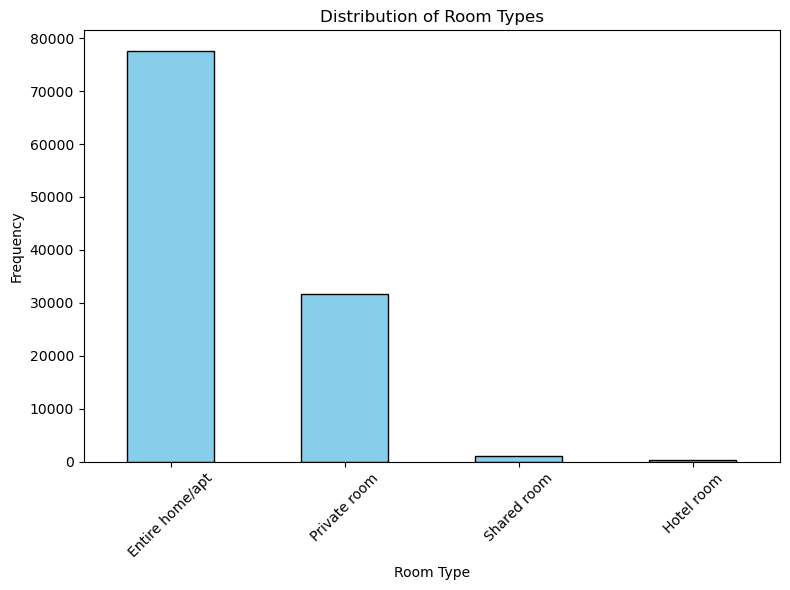

In [12]:
# room type distribution

# distribution of room types
room_type_distribution = df_cleaned['room_type'].value_counts()

# display distribution
print(room_type_distribution)

# visualize distribution with bar plot
plt.figure(figsize=(8, 6))
room_type_distribution.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Room Types')
plt.xlabel('Room Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The dataset reflects the general trend that Airbnb guests tend to prefer renting entire homes or apartments. This could be due to the desire for more space, privacy, or the kind of experience these accommodations provide compared to more communal living arrangements like shared rooms or hotel rooms.

## City and State Based Analysis ##